In [5]:
import json
import abc
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime, timedelta
from pytz import UTC
import pickle
with open(".secret", 'r') as f:
    apikeys = json.loads(f.read())

In [3]:
apikeys

{'metObs': '719f0415-0e36-416a-9b58-b64d7a60d7d0',
 'forecast': '35fd2315-5551-4333-a833-3f90f0dfafc9'}

In [6]:
with open("dmi_last_2_year.bin", 'rb') as f:
    data = pickle.loads(f.read())
f.close()

In [4]:
class weather_int(abc.ABC):
    @abc.abstractmethod
    def __init__(self, starttime: datetime, endtime: datetime) -> None:
        self._starttime = starttime
        self._endtime = endtime

    @property
    def endtime(self):
        return self._endtime.astimezone(UTC)
    
    @endtime.setter
    def endtime(self, date: datetime):
        self._endtime = date

    @property
    def starttime(self):
        return self._starttime.astimezone(UTC)
    
    @starttime.setter
    def starttime(self, date: datetime):
        self._starttime = date

    @abc.abstractmethod
    def output_csv(self, data, print_header = True, filename = "./weather.csv" ):
        pass

    @abc.abstractmethod
    def extract_weather(self):
        pass




class metObs(weather_int):
    _apikey = "api-key=" + apikeys["metObs"]
    _baselink = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items/?"
    def __init__(self, starttime: datetime, endtime: datetime, station = 6030) -> None:
        super().__init__(starttime, endtime)
        self._station = station  # Default Aalborg
        # Set parameter config
        self._parameter_id = {
            "humidity":[True, 10, "%"],
            "precip_dur_past10min":[True, 10, "kg/m²"],
            "precip_past10min":[True, 10, "min"],
            "precip_past1min":[True, 10, "min"],
            "pressure":[True, 10, "hPa"],
            "pressure_at_sea":[False, 10, "hPa"],
            "temp_dew":[True, 10, "degC"],
            "temp_dry":[True, 10, "degC"],
            "temp_grass":[False, 10, "degC"],
            "visib_mean_last10min":[False, 10, "m"],
            "visibility":[False, 10, "m"],
            "weather":[False, 10, "Code"],
            "wind_dir":[False, 10, "degree"],
            "wind_max":[False, 10, "m/s"],
            "wind_min":[False, 10, "m/s"],
            "wind_speed":[False, 10, "m/s"],
            "precip_dur_past1h":[False, 60, "min"],
            "precip_past1h":[False, 60, "kg/m²"],
            "temp_max_past1h":[False, 60, "degC"],
            "temp_mean_past1h":[False,60, "degC"],
            "temp_min_past1h":[False, 60, "degC"],
            "humidity_past1h":[False, 60, "%"],
            "temp_grass_max_past1h":[False,60,"degC"],
            "temp_grass_mean_past1h":[False,60,"degC"],
            "temp_grass_min_past1h":[False,60,"degC"],
            "wind_dir_past1h":[False,60,"degree"],
            "wind_gust_always_past1h":[False,60,"m/s"],
            "wind_max_per10min_past1h":[False,60,"m/s"],
            "wind_min_past1h":[False,60,"m/s"],
            "wind_speed_past1h":[False,60,"m/s"],
            }

    # Dataclass for processed JSON Query.    
    class metObsSample:
        def __init__(self, sample) -> None:
            properties = sample["properties"]
            try:
                self.coord = sample["geometry"]["coordinates"]
            except:
                self.coord = None
            self.observedTime = datetime.strptime(properties["observed"], "%Y-%m-%dT%H:%M:%S%z")
            self.parameterId = properties["parameterId"]
            self.value = properties["value"]
            pass 
    
    @property
    def station(self):
        if self._station / 10000 < 1:
            return "0" + str(self._station)
        else:
            return str(self.station)
    
    @station.setter
    def station(self, val:int):
        self._station = val

    @property
    def query_date(self):
        format_string = "%Y-%m-%dT%H:%M:%SZ"
        starttime = datetime.strftime(self.starttime - timedelta(minutes=self.starttime.minute, seconds=self.starttime.second), format_string)
        endtime = datetime.strftime(self.endtime - timedelta(minutes=self.endtime.minute, seconds=self.endtime.second), format_string)
        return f"{starttime}/{endtime}"

    @property
    def parameters(self):
        keys = list(self._parameter_id.keys())
        params = list(key for key in keys if self._parameter_id[key][0] == True)
        return params
    @parameters.setter
    def parameters(self, parameter): 
        self._parameter_id[parameter][0] = not self._parameter_id[parameter][0] 
        return

    # Request a parameter from DMI API.
    def _extract_parameter(self, parameter: str):
        count = int((self.endtime - self.starttime).total_seconds() // (self._parameter_id[parameter][1]*60))
        query = self._baselink + self._apikey + f"&stationId={self.station}&parameterId={parameter}&datetime={self.query_date}&limit={str(count+500)}"
        r = requests.request("GET", query)
        x = [self.metObsSample(index) for index in json.loads(r.content)["features"]]
        return x
    
    #Extract All active paramters from DMI.
    def extract_weather(self, sorttime = False):
        output = {}
        for param in self.parameters:
            tmp = self._extract_parameter(param)
            if len(tmp) == 0:
                    self.parameters = param # Remove from parameter list
                    continue
            if sorttime:
                for data in tmp:
                    if data.observedTime not in output:
                        output[data.observedTime] = {param:data.value}
                    else:
                        output[data.observedTime][param] = data.value
            else:
                output[param] = tmp
        if sorttime: output =  {date:output[date] for date in sorted(output)}
        return output
    
    # Format as CSV, and print to file 
    def output_csv(self, data, print_header=True, filename="./weather.csv"):
        def generate_line(line):
            output = line[0]
            for i in line[1:]:
                output = output + "," + str(i)
            return output
        format_str = "%Y-%m-%dT%H:%M:%SZ"
        params = self.parameters
        header1 = generate_line(["Time"] + params)
        header2 = generate_line(["UTC"] + list(self._parameter_id[x][2] for x in params))    
        with open(filename, 'w') as f:
            if print_header:
                f.write(header1 + "\n")
                f.write(header2 + "\n")
            for item in data:
                line = [datetime.strftime(item, format_str), *(0 for _ in range(len(params)))] 
                for i, param in enumerate(params):
                    if param in data[item]:
                        line[i+1] = data[item][param]
                    else:
                        line[i+1] = "NaN"
                f.write(generate_line(line) + "\n")
        return
    







In [4]:
metobs = metObs(datetime.now() - timedelta(days=365*2), datetime.now())


In [5]:
data = metobs.extract_weather()

In [6]:
data.keys()

dict_keys(['humidity', 'precip_dur_past10min', 'precip_past10min', 'precip_past1min', 'pressure', 'temp_dew', 'temp_dry'])

In [7]:
precip10 = data["precip_dur_past10min"]

In [8]:
precip_val = np.array([i.value for i in precip10])

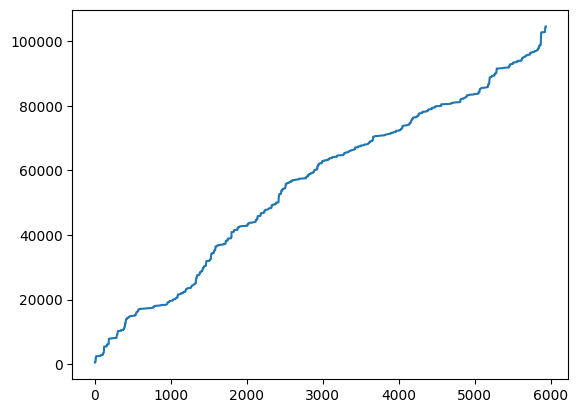

In [9]:
plt.plot(np.argwhere(precip_val > 0))

In [46]:
np.mean(precip_val[precip_val > 0])

np.float64(2.1325138912274793)

Text(0.5, 1.0, 'No rain included')

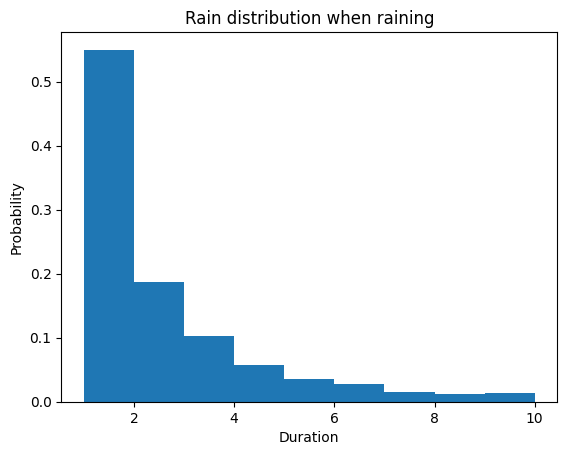

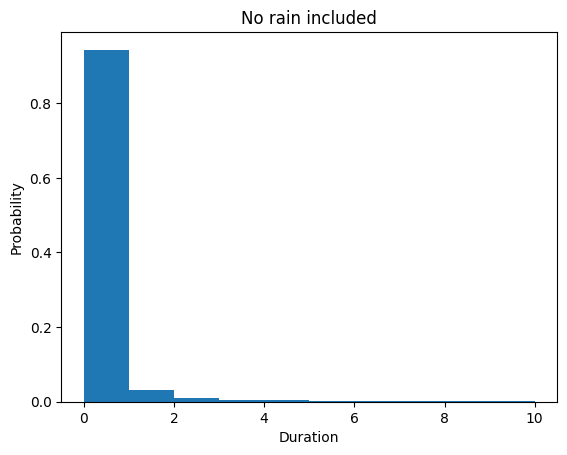

In [12]:
vals = precip_val[precip_val > 0]
plt.hist(vals, 9, weights=np.ones_like(vals)/len(vals))
plt.xlabel("Duration")
plt.ylabel("Probability")
plt.title("Rain distribution when raining")
plt.figure()
plt.xlabel("Duration")
plt.ylabel("Probability")
plt.hist(precip_val, 10, weights=np.ones_like(precip_val)/len(precip_val))
plt.title("No rain included")

In [63]:
print(precip10[0].observedTime)
print(precip10[1].observedTime)


2025-05-06 09:00:00+00:00
2025-05-06 08:50:00+00:00


In [15]:
import pickle
bin = pickle.dumps(data)

In [17]:
with open("dmi_last_2_year.bin", "wb") as f:
    f.write(bin)

In [59]:
precip_1m = data["precip_past1min"]
precip_1m_val = np.array([i.value for i in precip_1m])
precip_1m_time = np.array([i.observedTime.timestamp() for i in precip_1m])
# precip_1m_time = precip_1m_time - precip_1m_time[0]
precip_10m = data["precip_past10min"]
precip_10m_val = np.array([i.value for i in precip_10m])
precip_10m_time = np.array([i.observedTime.timestamp() for i in precip_10m])


In [63]:
%matplotlib tk
plt.plot(precip_1m_val)
plt.figure()
plt.scatter(precip_1m_time, precip_1m_val)
plt.scatter(precip_10m_time, precip_10m_val, color="tab:orange")